# Background 
This code implements a spiking neural net with conductance in input. the following equations govern the dynamic of the network. 
### transmembrane voltage dynamics
first we model the transmembrane voltage as 
$$\tau_m \frac{dV_i}{dt}= - V_i(t)+ R_m \times I^{syn}_i(t) $$ 
$$ {\tau_a}_i \frac{dB_i(t)}{dt} = b_i^0 -B_i(t)$$ 
where, $R_m$ is membrane resistance, $\tau_m$ is membrane time constant, and ${\tau_a}_i$ is adaptation time constant  .
the synaptic current relates to synaptic activations in the following way
$$I^{syn}_i(t)= \sum_j W^{in}_{ij} \times X(t) + \sum_j W^{rec}_{ij} \times S_j(t) $$ 

### neuron firing dynamics 
The firing dynamics of the neuron is model as a simple reseting. More specifically, 
$$V_i \rightarrow V_{reset} \ \ \  if \ \ \ V_i>=B_{i} $$

$ V_{\Theta}$ represent the threshold voltage and $V_{reset}$ is the reset voltage of the neuron.

### Input dynamics 
Input synapes are the the site of learning in the spiking network. Below a conductance based formulation is presented. 
First, the time-dependent input conductance to membrane is calculated as follows 
$$ g_i(t) = \sum_j W_{ij} S_{j}(t) $$

in the current version $S_{j}(t)$ is equal to spike at timestep $t$ without any decay dynamics. 
-  TODO the term $j$ reperesent all the neurons that have a synapse onto the neuron $i$. the time dependence of conductance is due to $S(t)$ which represent the spiking activity for neurons connected to neuron $i$ . The spiking activity has the following governing equations 
$$ S_{j} \rightarrow S_{j}+1 \quad if \ neuron\ j\ fires$$
$$ \frac{dS_{j}(t)}{dt} = \frac{-S_{j}(t)}{\tau_s}$$ 

### Spike Adaptation dynamics 
The threshold for spiking increases with every spike emited from a neuron with the following dynamics 
$$ B_{i}(t) \rightarrow B_{i}(t)+\frac{\beta}{{\tau_a}_i} \quad if \ neuron\ i\ fires$$

### References 
-  Fiete, Ila R., Walter Senn, Claude Z. H. Wang, and Richard H. R. Hahnloser. 2010. “Spike-Time-Dependent Plasticity and Heterosynaptic Competition Organize Networks to Produce Long Scale-Free Sequences of Neural Activity.” Neuron 65 (4): 563–76. 

-  Bellec, Guillaume, Darjan Salaj, Anand Subramoney, Robert Legenstein, and Wolfgang Maass. 2018. “Long Short-Term Memory and Learning-to-Learn in Networks of Spiking Neurons.” arXiv [cs.NE]. arXiv. http://arxiv.org/abs/1803.09574.



### notes about the implementation 
-  both input and recurrent weight are combined into 1 kernel matrix 


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm

import numpy as np
import tensorflow as tf

import collections
import hashlib
import numbers

from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import partitioned_variables
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import tensor_array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util import nest
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _Linear
from tensorflow.contrib import slim
import spiking_cell

first testing the code on a constant input 

In [ ]:
batch_size = 1
sequence_length = 50
num_inputs=1
num_units=1
#input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
input_spikes=1.0*np.ones([batch_size,sequence_length,num_inputs])
tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
conductance_SNN = spiking_cell.conductance_spike_Cell(num_units=num_units,
                                         state_is_tuple=True,
                                         output_is_tuple=True,
                                         tau_s=10.0,
                                         tau_refract=5.0,
                                        kernel_initializer=tf.initializers.identity(),
                                        bias_initializer=tf.initializers.zeros())
outputs, state = tf.nn.dynamic_rnn(cell=conductance_SNN, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 
plt.figure(figsize=[15,30])
ax=plt.subplot(5,1,1)
ax.plot(output_run.v_mem.flatten())
ax.set_title('v_mem')
ax=plt.subplot(5,1,2)
ax.plot(output_run.S.flatten())
ax.set_title('spikes')
ax=plt.subplot(5,1,3)
ax.plot(output_run.t_reset.flatten())
ax.set_title('t_reset')
ax=plt.subplot(5,1,4)
ax.plot(output_run.Beta.flatten())
ax.set_title('Beta')
ax=plt.subplot(5,1,5)
ax.plot(output_run.b_threshold.flatten())
ax.set_title('b_threshold')


next we create a recurrent version to verify the functionality 

In [ ]:
batch_size = 1
sequence_length = 50
num_inputs=2
num_units=4
#input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
input_spikes=1.0*np.ones([batch_size,sequence_length,num_inputs])
tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
conductance_SNN = spiking_cell.conductance_spike_Cell(num_units=num_units,
                                         state_is_tuple=True,
                                         output_is_tuple=True,
                                         tau_s=10.0,
                                         tau_refract=5.0,
                                        kernel_initializer=tf.initializers.identity(),
                                        bias_initializer=tf.initializers.zeros())
outputs, state = tf.nn.dynamic_rnn(cell=conductance_SNN, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 
plt.figure(figsize=[15,30])
ax=plt.subplot(5,1,1)
ax.plot(output_run.v_mem.squeeze(axis=0))
ax.set_title('v_mem')
ax=plt.subplot(5,1,2)
ax.plot(output_run.S.squeeze(axis=0))
ax.set_title('spikes')
ax=plt.subplot(5,1,3)
ax.plot(output_run.t_reset.squeeze(axis=0))
ax.set_title('t_reset')
ax=plt.subplot(5,1,4)
ax.plot(output_run.Beta.squeeze(axis=0))
ax.set_title('Beta')
ax=plt.subplot(5,1,5)
ax.plot(output_run.b_threshold.squeeze(axis=0))
ax.set_title('b_threshold')


### output spike cell 
next we simulate an output spiking cell similar to Bellec

In [ ]:
batch_size = 1
sequence_length = 200
num_inputs=20
num_units=10
#shape=(2, 5, 2)
input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs]).astype(np.float32)
#input_spikes=np.ones([batch_size,sequence_length,num_inputs])

tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
output_voltage_cell = spiking_cell.output_spike_cell(num_units=num_units,kernel_initializer=tf.initializers.identity())
outputs, state = tf.nn.dynamic_rnn(cell=output_voltage_cell, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k ,v.shape) 
plt.figure(figsize=[15,10])
ax=plt.subplot(3,1,1)
unit_colors=cm.viridis(np.linspace(0,1,num_units))
for t in range(num_units):
    ax.plot(output_run.squeeze(axis=0)[:,t],color=unit_colors[t,:])
ax.set_title('v_out')
input_spikes.dtype=np.float32
input_spikes[input_spikes==0.0]=np.nan
ax=plt.subplot(3,1,2)
colors_map=cm.viridis(np.linspace(0,1,num_inputs))
for t in range(num_inputs):
    ax.scatter(np.arange(input_spikes.squeeze(axis=0).shape[0]),input_spikes.squeeze(axis=0)[:,t]+t,color=colors_map[t,:],s=3)
ax.set_title('input spikes')

### input spike cell 
next we simulate an input spiking cell based on a threshold. 

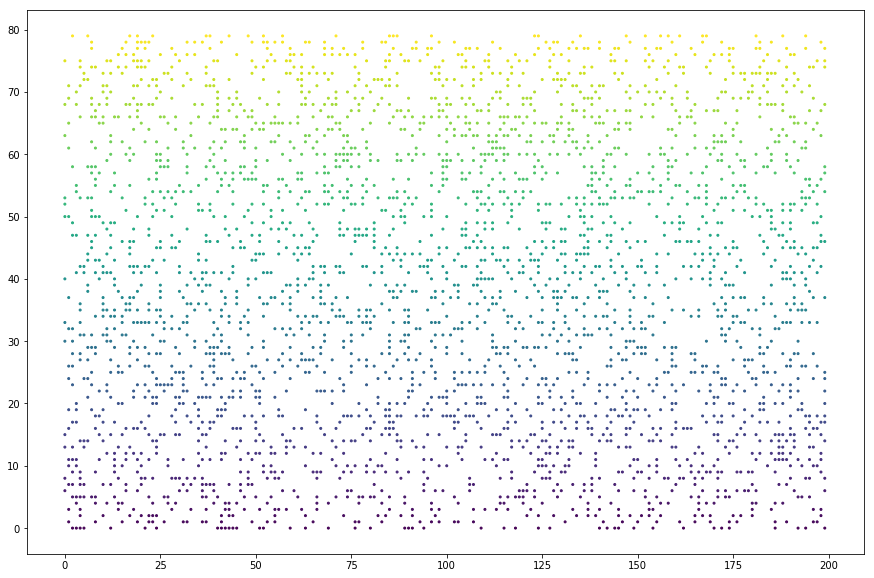

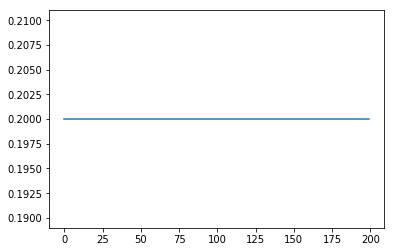

In [5]:
batch_size = 1
sequence_length = 200
num_inputs=1
num_units=80
#shape=(2, 5, 2)
#input_spikes=np.random.uniform(size=[batch_size,sequence_length,num_inputs]).astype(np.float32)/6
input_spikes=.2*np.ones([batch_size,sequence_length,num_inputs])

tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
LSNNInput_Cell = spiking_cell.input_spike_cell(num_units=num_units)
outputs, state = tf.nn.dynamic_rnn(LSNNInput_Cell, dtype=tf.float32, inputs=tf_input_values)


cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 

plt.figure(figsize=[15,10])
colors_map=cm.viridis(np.linspace(0,1,2*40))
for t in range(sequence_length):
    cross=np.argwhere(output_run.squeeze(axis=0)[t,:])
    plt.scatter(cross*0+t,cross,color=colors_map[cross.flatten(),:],s=4)
plt.figure()
plt.plot(np.transpose(input_spikes.squeeze(axis=2)))